
<p>In this notebook, we will detect how closely related Charles Darwin's books are to each other.</p>
<p>To this purpose, we will develop <strong>a content-based book recommendation system</strong>, which will determine which books are close to each other based on how similar the discussed topics are. 
<p>Here are the books used in the recommendation system below.</p>

In [1]:
# Import PyDrive and associated libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

file_list = drive.ListFile(
    {'q': "'1PgXqJ_WUsFU58vH6NOeKBzW9PcbcZKaq' in parents"}).GetList()


<p>Loading the contents of each book into Python to do some basic pre-processing to facilitate the downstream analyses. That is creating <strong>a corpus</strong>. Also will store the titles for these books for future reference and print their respective length to get a gauge for their contents.</p>

In [15]:
import re

fnames = []
titles = []
for f in file_list:
  titles.append(f['title'].split('.')[0])
  fname = os.path.join(local_download_path, f['title'])
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  fnames.append(fname)

print(fnames[:2])

['/root/data/Autobiography.txt', '/root/data/CoralReefs.txt']


In [16]:
txts = []
for fn in fnames:
  with open(fn, 'r') as f:
    pattern = re.compile('[^a-zA-Z0-9\s]+')
    text = pattern.sub('', f.read())
    txts.append(text)

[len(t) for t in txts]

[123229,
 496539,
 1785723,
 616671,
 919542,
 624250,
 342689,
 534797,
 796499,
 904003,
 1047646,
 1014384,
 777741,
 1723333,
 305219,
 919177,
 1094855,
 1084841,
 341193,
 1154047]


<p>For the next parts of this analysis, we will often check the results returned by our method for a given book. For consistency, we will refer to Darwin's most famous book: "<em>On the Origin of Species</em>." Let's find to which index this book is associated.</p>

In [17]:
titles_idx = {}
for i in range(len(titles)):
    # Storing the index of the titles for future reference
    titles_idx[titles[i]] = i

# Print the stored index
print(titles_idx['OriginofSpecies'])

11



<p>Tokenizing and removing stop words from the text.</p>

In [18]:
# Defined a list of stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

txts_lower_case = [txt.casefold() for txt in txts]

# Transforming the text into tokens 
txts_split = [txt.split() for txt in txts_lower_case]

# Remove tokens which are part of the list of stop words
texts = [[txt for txt in txts_split[i] if txt not in stoplist] for i in range(len(txts_split))]

# Printing the first 20 tokens for the "On the Origin of Species" book
print(texts[titles_idx['OriginofSpecies']][:20])

['life', 'letters', 'charles', 'darwin', 'including', 'an', 'autobiographical', 'chapter', 'edited', 'by', 'his', 'son', 'francis', 'darwin', 'two', 'volumes', 'volume', 'ii', 'table', 'contents']



Building a bag-of-words model

In [32]:
from gensim import corpora

# Creating a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts)

bows = [dictionary.doc2bow(book) for book in texts]

# Printing the first five elements of the On the Origin of species' BoW model
bows[titles_idx['OriginofSpecies']][:5]

[(0, 34), (1, 12), (2, 6), (3, 7), (4, 7)]


Finding the most common words of a given book

In [33]:
import pandas as pd

# Converting the BoW model for "On the Origin of Species" into a DataFrame
df_bow_origin = pd.DataFrame(bows[titles_idx['OriginofSpecies']])

# Adding the column names to the DataFrame
df_bow_origin.columns = ["index", "occurences"]
df_bow_origin.head()

# Adding a column containing the token corresponding to the dictionary index
df_bow_origin['token'] = [dictionary[i] for i in df_bow_origin['index']]
df_bow_origin.tail()

# Sorting the DataFrame by descending number of occurrences and print the first 10 values
df_bow_origin.sort_values(by='occurences', ascending=False).head(10)

,index,occurences,token
2847,3620,2118,you
1225,1559,2083,have
1430,1818,1928,it
1808,2306,1848,on
1618,2064,1370,me
1757,2244,1286,not
2804,3570,1247,with
1227,1563,1204,he
395,503,1136,by
2850,3623,1114,your



Building a tf-idf model

In [34]:
from gensim.models import TfidfModel

# Generate the tf-idf model
model = TfidfModel(bows)

model[bows[titles_idx['OriginofSpecies']][:5]]

[(1, 0.5868992480438079),
 (2, 0.5868992480438079),
 (3, 0.3943973537507736),
 (4, 0.3943973537507736)]

The results of the tf-idf model

In [35]:
# Converting the tf-idf model for "On the Origin of Species" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[titles_idx['OriginofSpecies']]])
df_tfidf.head()

df_tfidf.columns = ['id', 'scores']

# Adding the tokens corresponding to the numerical indices for better readability
df_tfidf['token'] = [dictionary[i] for i in df_tfidf.id]
df_tfidf.tail()

df_tfidf.sort_values(by='scores', ascending=False).head(10)

,id,scores,token
2160,3620,0.534428,you
2162,3623,0.452289,your
504,845,0.385569,dear
8684,37107,0.330436,yours
7251,25593,0.110297,sincerely
6258,18162,0.104749,thank
3062,5910,0.096629,jd
1004,1667,0.079970,huxley
778,1281,0.069118,father
1662,2769,0.067875,reviews



Computing distance between texts

In [36]:
from gensim import similarities

# Computing the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])

sim_df = pd.DataFrame(list(sims))
sim_df.head()

sim_df.columns = titles
sim_df.index = titles

sim_df.head(10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,VoyageBeagle,VolcanicIslands,VariationPlantsAnimalsDomestication,InsectivorousPlants,ExpressionofEmotionManAnimals,DifferentFormsofFlowers,LifeandLettersVol2,CoralReefs,MovementClimbingPlants,LifeandLettersVol1,EffectsCrossSelfFertilization,OriginofSpecies,Autobiography,GeologicalObservationsSouthAmerica,FormationVegetableMould,PowerMovementPlants,FoundationsOriginofSpecies,MonographCirripedia,MonographCirripediaVol2,DescentofMan
VoyageBeagle,0.999999,0.037763,0.073565,0.022984,0.027009,0.071788,0.019474,0.044818,0.027382,0.012950,0.363053,0.200348,0.005080,0.009030,0.013021,0.079280,0.011180,0.039296,0.035690,0.132210
VolcanicIslands,0.037763,1.000000,0.010383,0.001398,0.001680,0.005364,0.013977,0.018302,0.061831,0.002842,0.028983,0.016621,0.006103,0.009181,0.001958,0.036184,0.003183,0.011473,0.063734,0.166171
VariationPlantsAnimalsDomestication,0.073565,0.010383,1.000000,0.033310,0.022647,0.153524,0.016441,0.112429,0.010988,0.009909,0.061371,0.077041,0.045483,0.038314,0.007139,0.226864,0.013693,0.199883,0.010202,0.115582
InsectivorousPlants,0.022984,0.001398,0.033310,1.000000,0.151034,0.003635,0.003259,0.018826,0.001918,0.004797,0.006986,0.022492,0.004660,0.002968,0.005972,0.070300,0.010728,0.029712,0.001863,0.006735
ExpressionofEmotionManAnimals,0.027009,0.001680,0.022647,0.151034,0.999999,0.004913,0.013041,0.025165,0.002772,0.006275,0.011643,0.020331,0.002366,0.002315,0.011952,0.093353,0.032216,0.037963,0.002200,0.012626
DifferentFormsofFlowers,0.071788,0.005364,0.153524,0.003635,0.004913,0.999999,0.012178,0.034316,0.006004,0.011990,0.060973,0.045858,0.015729,0.024753,0.008899,0.052914,0.012706,0.071271,0.006461,0.084771
LifeandLettersVol2,0.019474,0.013977,0.016441,0.003259,0.013041,0.012178,1.000001,0.009199,0.031920,0.020830,0.014461,0.013121,0.010840,0.012107,0.016173,0.024094,0.022207,0.015919,0.031195,0.050351
CoralReefs,0.044818,0.018302,0.112429,0.018826,0.025165,0.034316,0.009199,1.000000,0.025709,0.004637,0.048700,0.045122,0.007037,0.009449,0.004196,0.252211,0.007562,0.135802,0.017466,0.066331
MovementClimbingPlants,0.027382,0.061831,0.010988,0.001918,0.002772,0.006004,0.031920,0.025709,1.000000,0.008895,0.027908,0.012986,0.009981,0.018159,0.003022,0.054862,0.004830,0.013103,0.378581,0.233478
LifeandLettersVol1,0.012950,0.002842,0.009909,0.004797,0.006275,0.011990,0.020830,0.004637,0.008895,1.000000,0.006026,0.016261,0.018050,0.021305,0.285608,0.013063,0.025108,0.009410,0.011479,0.014205



The book most similar to "On the Origin of Species"

Text(0.5, 1.0, "Most similar books to 'On the Origin of Species'")

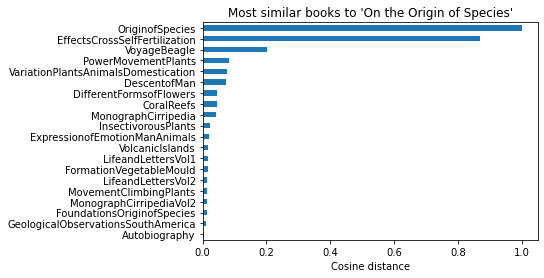

In [37]:

%matplotlib inline
import matplotlib.pyplot as plt

# Selecting the column corresponding to "On the Origin of Species" and 
v = sim_df['OriginofSpecies']

v_sorted = v.sort_values()
v_sorted[:5]

plot_sim = v_sorted.plot.barh(x='lab', y='val', rot=0).plot()

plt.xlabel("Cosine distance")
plt.ylabel("")
plt.title("Most similar books to 'On the Origin of Species'")


## Books having similar content

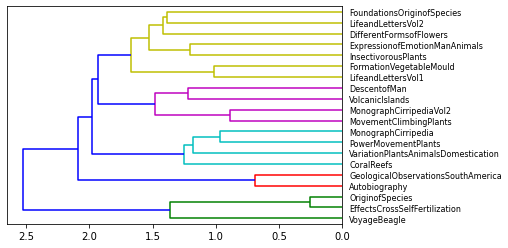

In [38]:
from scipy.cluster import hierarchy

# Computeing the clusters from the similarity matrix, using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df, 'ward')

# Displaying this result as a horizontal dendrogram
a = hierarchy.dendrogram(Z, leaf_font_size=8, labels=sim_df.index, orientation='left')